## VAE

Import required packages

In [2]:
import torch
from torch import optim
from ResVAE import ResVariationalAutoEncoder  # Assuming you have a VAE model defined in 'model.py'
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from train import load_cw
import h5py
from geodesicwelding import geodesicwelding


DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
MAT_PATH = 'data/preprocessed.mat'

cw = load_cw(MAT_PATH)
cw_tensor = torch.tensor(cw)
train_data = TensorDataset(cw_tensor)

Training

In [3]:
# Configuration

INPUT_DIM = 100  # Adjusted input dimension to match your complex data
H_DIM = 1000
Z_DIM = 2
H_LAYERS = [2]
LR_RATE = 1e-3
BATCH_SIZE = 1024

torch.manual_seed(717)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

## Init model
model = ResVariationalAutoEncoder(input_dim=INPUT_DIM, h_dim=H_DIM, h_layers=H_LAYERS, z_dim=Z_DIM).to(DEVICE)
model.initial()

## Load model
# model = torch.load('VAE_theta+bias1.pth')

optimizer = optim.Adam(model.parameters(), lr=LR_RATE, weight_decay=1e-5, betas=(0.5, 0.999))
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8000], gamma=0.5)

model.to(DEVICE)

loader_size = len(train_loader)
loss_list_dict = {}
# loss_list = np.zeros(loader_size)  # To store reconstruction diff losses
# recon_loss_list = np.zeros(loader_size)  # To store reconstruction losses
# kl_loss_list = np.zeros(loader_size)         # To store KL divergence losses


In [4]:
NUM_EPOCHS = 20000

def get_kl_rate(epoch, n=500, m=1000):
    if epoch < m:
        return 0
    else:
        return (epoch % n) / n

kl_rate = 0.1
model.train()
for epoch in range(NUM_EPOCHS):
    for i, [data] in enumerate(train_loader):
        data = data.to(DEVICE, dtype=torch.float32).view(data.shape[0], INPUT_DIM)
        x_reconstructed, mu, sigma = model(data)

        # Compute loss
        # kl_rate = get_kl_rate(epoch)
        loss_dict = model.loss(x_reconstructed, data, mu, sigma, kl_rate)

        # Backprop
        optimizer.zero_grad()
        loss_dict['loss'].backward()
        optimizer.step()
        scheduler.step()
        
        # Append losses to the lists
        for k, v in loss_dict.items():
            if k not in loss_list_dict:
                loss_list_dict[k] = np.zeros(loader_size)
            
            loss_list_dict[k][i] = v.item()

    # Calculate and print average losses for this epoch
    # avg_loss = loss_list.sum() / data_size
    # avg_recon_loss = recon_loss_list.sum() / data_size
    # avg_kl_loss = kl_loss_list.sum() / data_size
    # avg_loss = loss_list.mean()
    # avg_recon_loss = recon_loss_list.mean()
    # avg_kl_loss = kl_loss_list.mean()
    # avg_true_loss = true_loss_list.mean()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{NUM_EPOCHS} | {', '.join([f'{k}: {v.mean():.4f}' for k, v in loss_list_dict.items()])}")
        
    if epoch % 1000 == 0:
        torch.save(model, './VAE_theta+bias1.pth')


Epoch 0/20000 | loss: 1332.2394, recon_loss: 1331.5924, kl_loss: 6.4700, true_loss: 2.1108
Epoch 100/20000 | loss: 50.2205, recon_loss: 48.3947, kl_loss: 18.2586, true_loss: 0.2129
Epoch 200/20000 | loss: 49.7652, recon_loss: 47.4847, kl_loss: 22.8052, true_loss: 0.2215
Epoch 300/20000 | loss: 45.7580, recon_loss: 43.8105, kl_loss: 19.4753, true_loss: 0.2192
Epoch 400/20000 | loss: 42.0587, recon_loss: 40.2705, kl_loss: 17.8816, true_loss: 0.1965
Epoch 500/20000 | loss: 43.5359, recon_loss: 41.8274, kl_loss: 17.0850, true_loss: 0.1952
Epoch 600/20000 | loss: 38.7263, recon_loss: 36.9985, kl_loss: 17.2785, true_loss: 0.1882
Epoch 700/20000 | loss: 34.9294, recon_loss: 33.0920, kl_loss: 18.3743, true_loss: 0.1675
Epoch 800/20000 | loss: 38.2379, recon_loss: 36.5529, kl_loss: 16.8501, true_loss: 0.1873
Epoch 900/20000 | loss: 34.1293, recon_loss: 32.3404, kl_loss: 17.8890, true_loss: 0.1682
Epoch 1000/20000 | loss: 39.7918, recon_loss: 38.2874, kl_loss: 15.0440, true_loss: 0.1850
Epoch 11

0.06283185 0.056060378


Text(0.5, 1.0, 'Original Distribution of Ground Truth ')

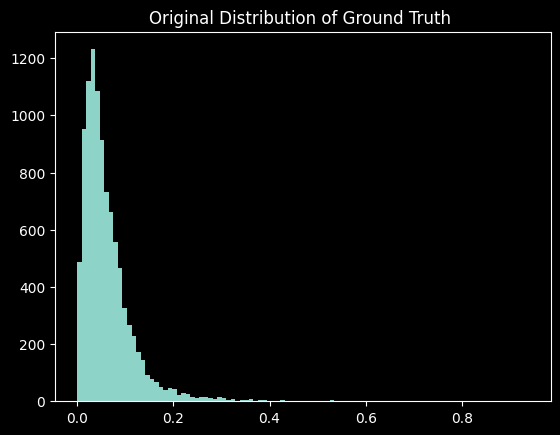

In [5]:
c =cw[np.random.choice(range(cw.shape[0]),100)]
p = 1/np.exp(c)
print(p.mean(), p.std())
plt.hist(p.reshape(-1), bins=100)
plt.title('Original Distribution of Ground Truth ')

3.1619792 1.0218688


Text(0.5, 1.0, 'Distribution of Ground Truth Activated by 1/e^x')

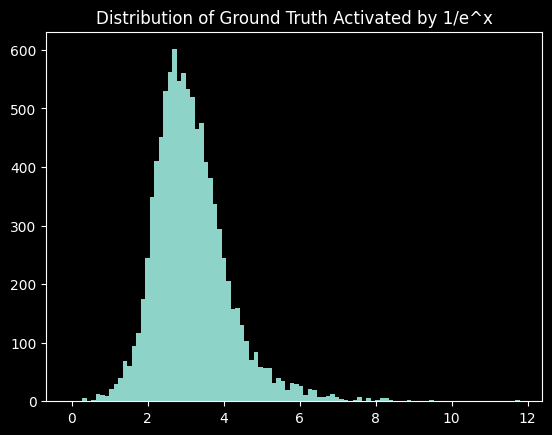

In [6]:
c =cw[np.random.choice(range(cw.shape[0]),100)]
print(c.mean(), c.std())
plt.hist(c.reshape(-1), bins=100)
plt.title('Distribution of Ground Truth Activated by 1/e^x')

tensor(3.0944, device='cuda:2', grad_fn=<MeanBackward0>) tensor(0.8037, device='cuda:2', grad_fn=<StdBackward0>)


Text(0.5, 1.0, 'Distribution of Generated Data')

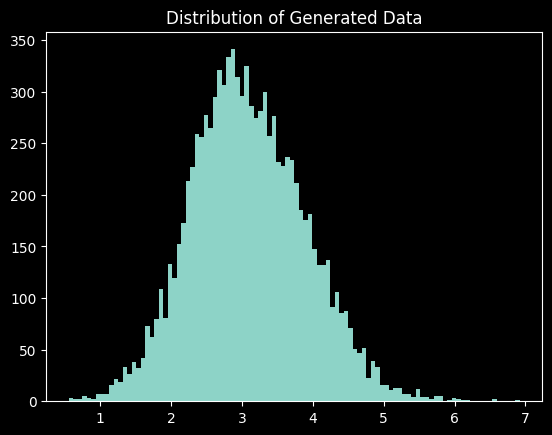

In [7]:
# print(model.mean, model.std)
z = torch.randn(100, Z_DIM).to(DEVICE).view(100, 1, Z_DIM)
h = model.decode(z)
print(h.mean(), h.std())
# h = 1/torch.exp(h+1e-8)
# h = h / torch.sum(h, dim=1, keepdim=True) * 2 * torch.pi
plt.hist(h.cpu().detach().numpy().reshape(-1), bins=100)
plt.title('Distribution of Generated Data')

Generate Data

In [8]:
def generate(num=1, mu_vals=None, sigma_vals=None, z_dim=Z_DIM):
    if mu_vals is None:
        mu = torch.zeros(1, z_dim).to(DEVICE, dtype=torch.float)
    else:
        mu = torch.tensor(mu_vals).to(DEVICE, dtype=torch.float).view(1, z_dim)

    if sigma_vals is None:
        sigma = torch.ones(1, z_dim).to(DEVICE, dtype=torch.float)
    else:
        sigma = torch.tensor(sigma_vals, dtype=torch.float).to(DEVICE).view(1, z_dim)

    generated_data = []
    
    model.eval()
    with torch.no_grad():
        for _ in range(num):
            z = model.sample(mu, sigma)
            out = model.decode(z)
            generated_data.append(out)

    # Convert the generated data to a numpy array
    generated_data = torch.cat(generated_data, dim=0)

    return generated_data.cpu().detach().numpy()


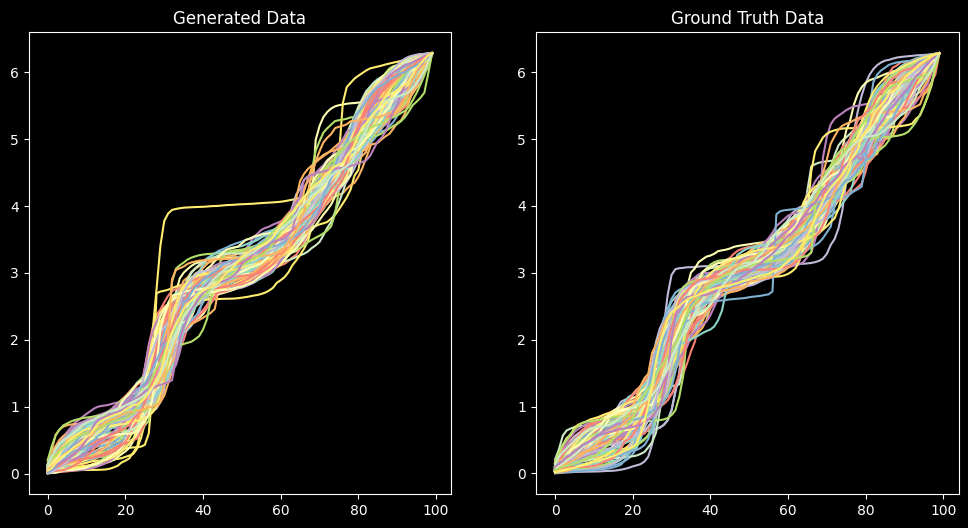

In [9]:
n = 100

# generated_data = h.view(-1, 100).cpu().detach().numpy()
generated_data = generate(num=n, sigma_vals=np.repeat(1, Z_DIM))
diff = 1 / (np.exp(generated_data) + 1e-8)
diff = diff / diff.sum(axis=1, keepdims=True) * 2 * np.pi
angle = np.cumsum(diff, axis=1)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.title.set_text('Generated Data')
for i in range(angle.shape[0]):
    ax.plot(angle[i])
    
ground_truth = cw[np.random.choice(range(cw.shape[0]),n)]
ground_truth_diff = 1 / (np.exp(ground_truth) + 1e-8)
ground_truth_diff = ground_truth_diff / ground_truth_diff.sum(axis=1, keepdims=True) * 2 * np.pi
ground_truth_angle = np.cumsum(ground_truth_diff, axis=1)

ax = fig.add_subplot(122)
ax.title.set_text('Ground Truth Data')
for i in range(ground_truth_angle.shape[0]):
    ax.plot(ground_truth_angle[i])

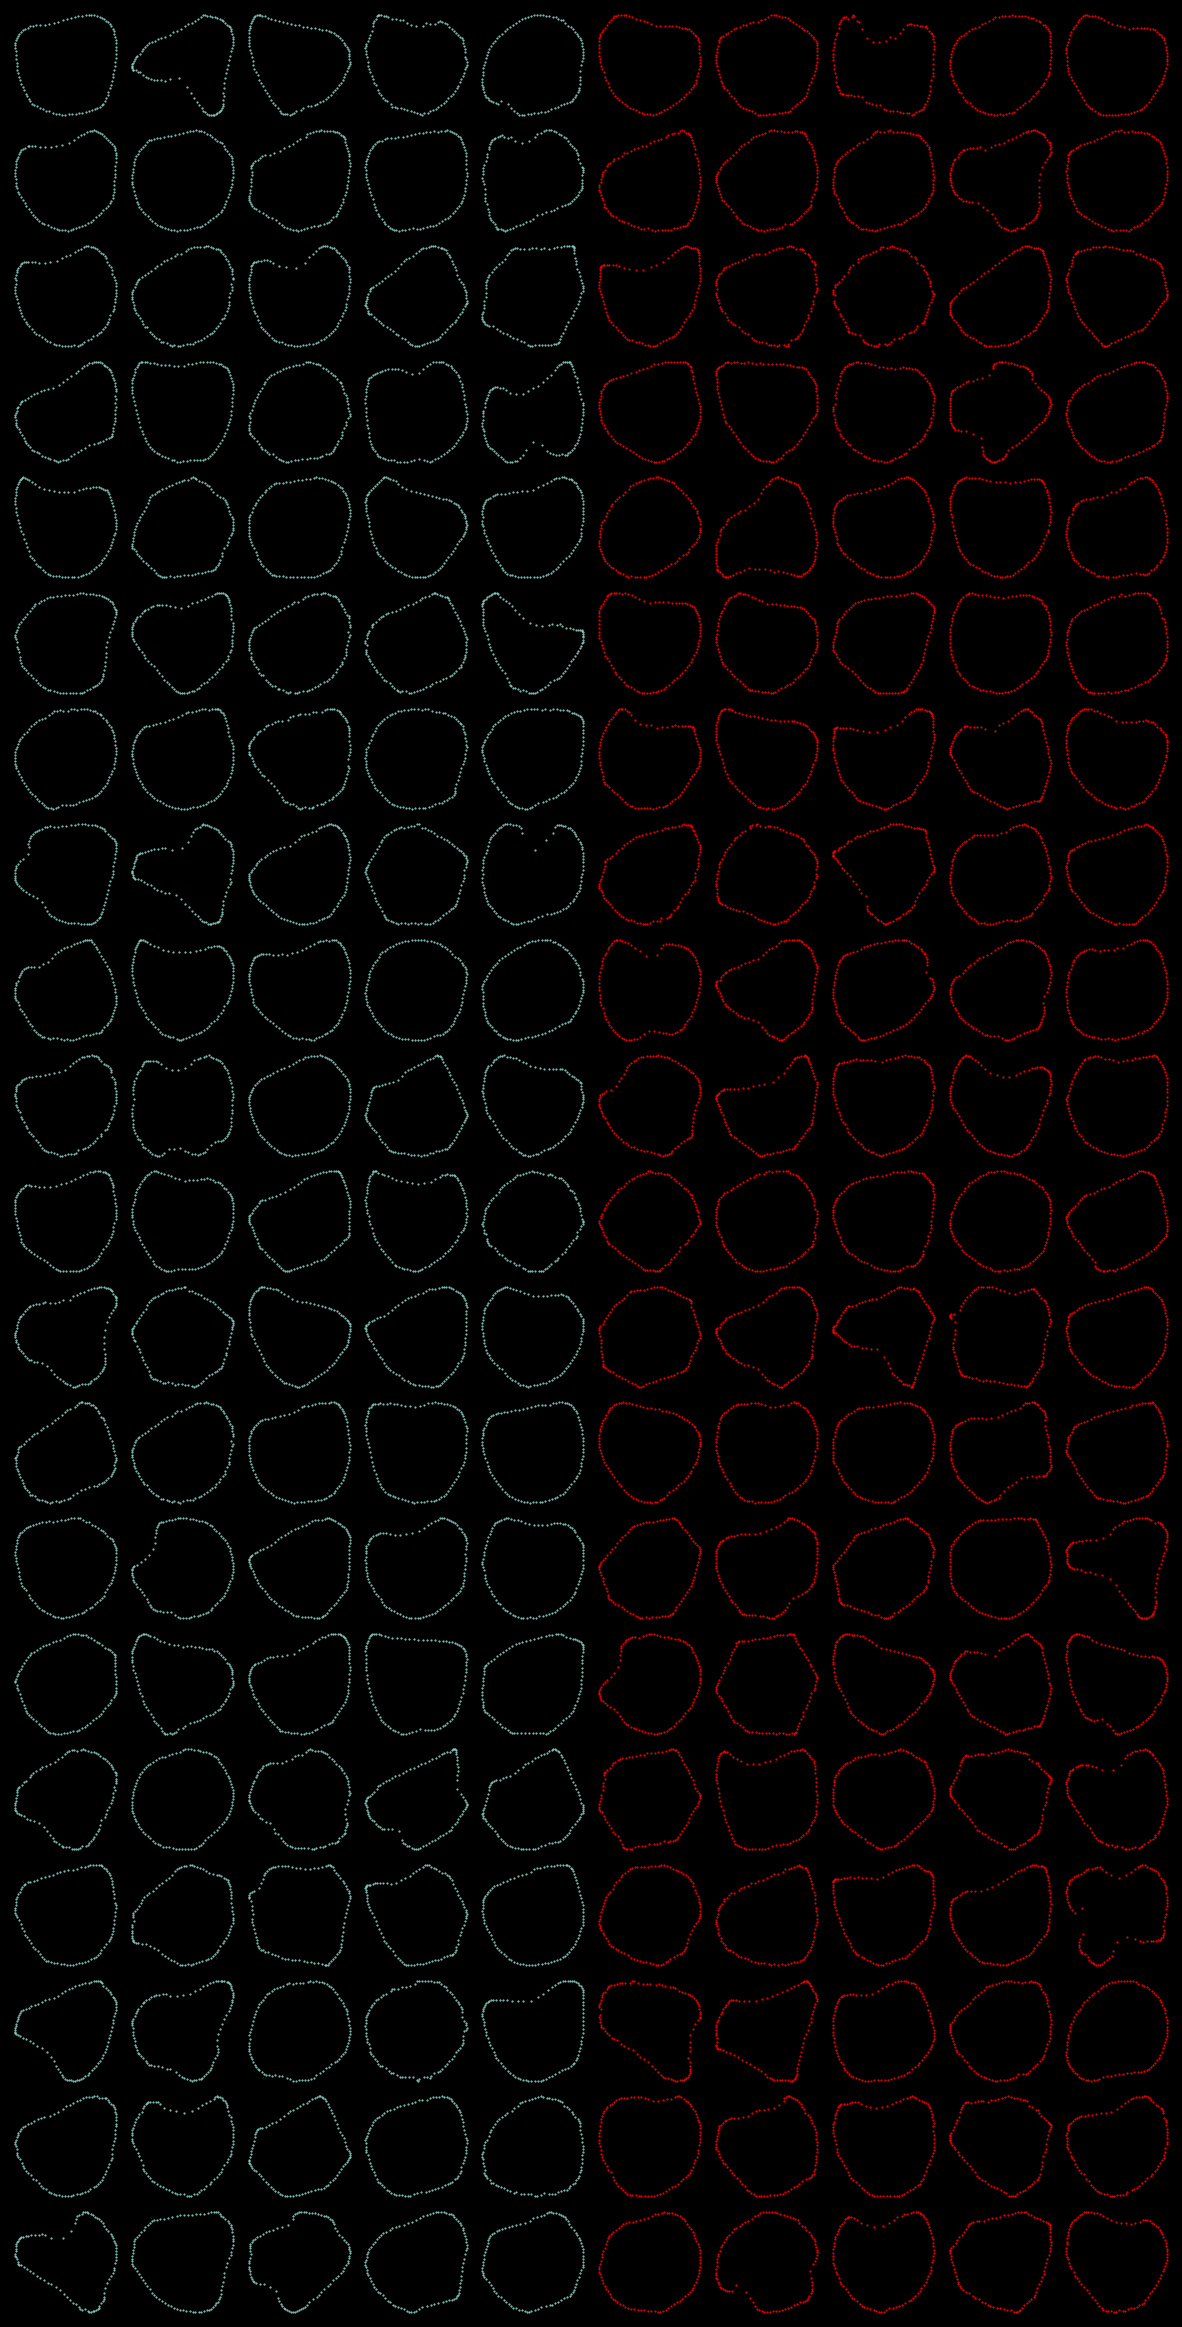

In [10]:
x = np.linspace(0, 2*np.pi, INPUT_DIM+1)[:INPUT_DIM]
xs = np.exp(1j * x)

x_num = 5
y_num = int(np.floor(2*n / x_num))
subfigure_size = 1.5

fig = plt.figure(figsize=(2*x_num*subfigure_size, y_num*subfigure_size))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Blue for generated data
for i in range(n):
    ys = np.exp(1j * angle[i])
    try:
        r, _ = geodesicwelding(ys, [], ys, xs)
    except:
        pass
    k = i//x_num*2*x_num + i%x_num+1
    plt.subplot(y_num, 2*x_num, k)
    plt.scatter(r.real, r.imag, s=0.3)
    plt.axis('off')

# Red for ground truth data
for i in range(n):
    ys = np.exp(1j * ground_truth_angle[i])
    try:
        r, _ = geodesicwelding(ys, [], ys, xs)
    except:
        pass
    k = i//x_num*2*x_num + i%x_num+1+x_num
    plt.subplot(y_num, 2*x_num, k)
    plt.scatter(r.real, r.imag, s=0.3, color='r')
    plt.axis('off')